# Analysis 6c - Run large-scale network model (simulation)

## Calculate correlation and variability during task state (input-driven) and rest state

#### Taku Ito
#### 03/18/2020
#### Python 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib as mpl
import sys
import model6c
import multiprocessing as mp
import statsmodels.api as sm
import seaborn as sns
import statsmodels.sandbox.stats.multicomp as mc
import pandas as pd
from importlib import reload

plt.style.use('ggplot')
sns.set(style='whitegrid',font='FreeSans',font_scale=2)

# For multiprocessing
nproc = 20

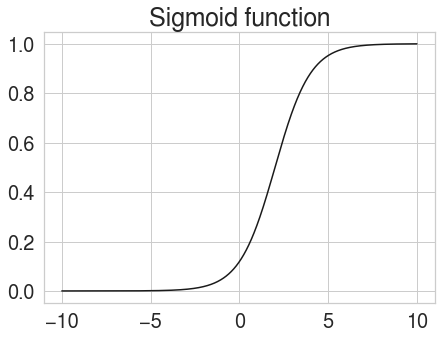

In [2]:
phi = lambda x: 1/(1+np.exp(-(x-2)))
x = np.arange(-10,10,0.01)
y = phi(x)
plt.figure(figsize=(7,5))
plt.plot(x,y,color='k')
plt.title('Sigmoid function',fontsize=25)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

# 1.0 Define functions

Let $x_i$, be neural mass model for region $i$. Define $w_ij$ to be the weight from neural mass $x_i$ to $x_j$.

To identify the rate of change for the firing rates for these neuronal populations, we have

$$\tau_i \frac{dx_i}{dt} = -x_i + f\Big( w_{ii} x_i + \sum_{j \neq i}^n \big(w_{ji} x_j \big) + b_i + s_i \Big) \qquad \qquad (1)$$


Where $f(x)$ refers to the sigmoid function, $\tau_i$ refers to the time constant of neuron $i$, and $s_i$ is the gain on neuron $i$.


# 2.0 Group simulation - sparse, random connectivity
* 2.1 - Excitatory connections only
* 2.2 - Excitatory and inhibitory connections (about 80/20% difference)


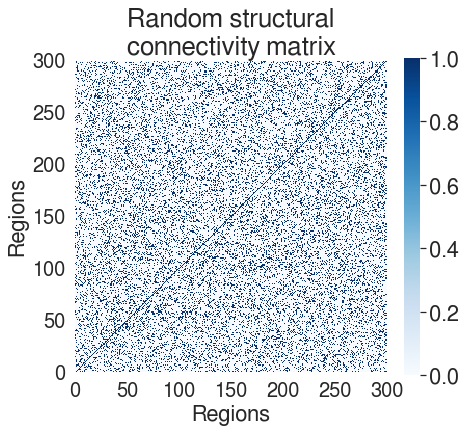

In [3]:
#### 1. Define network model parameters
# Parameters for subject's networks
ncommunities = 1 # Number of communities
nunits = 300
innetwork_dsity = 0.2 # within network connectivity density
outnetwork_dsity = 0.00 # out of network connectivity density
nodespercommunity=int(nunits/ncommunities)
s=1.0
g=2.0
nsubjs = 20

#### 2. Print out example structural matrix
mat = model6c.generateNetwork(ncommunities=ncommunities,innetwork_dsity=innetwork_dsity, outnetwork_dsity=outnetwork_dsity,
                      nodespercommunity=nodespercommunity,showplot=False)
np.fill_diagonal(mat,1)
plt.figure(figsize=(7,7))
plt.title('Random structural\nconnectivity matrix',fontsize=26)
ax = sns.heatmap(mat>0,square=True,cmap='Blues',cbar_kws={'fraction':0.046})
plt.xticks(np.arange(0,nunits+1,50),np.arange(0,nunits+1,50),fontsize=20,rotation=0)
plt.yticks(np.arange(0,nunits+1,50),np.arange(0,nunits+1,50),fontsize=20)
plt.ylabel('Regions',fontsize=22)
plt.xlabel('Regions',fontsize=22)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('Analysis6c_StructuralMat_Random.png',dpi=150)




## 2.1 Run group simulation, sparse, excitatory only
#### $\mu=1$ | $\sigma =0.2$ | 0% negative weights

In [4]:
model6c = reload(model6c)
synweights=0.2 # All connections will be E

#### Run simulation using multiprocessing
inputs = []
for i in range(nsubjs):
    seed = np.random.randint(1000000)
    inputs.append((i,seed,ncommunities,innetwork_dsity,outnetwork_dsity,nodespercommunity,s,g,synweights))
pool = mp.Pool(processes=nproc)
results = pool.starmap_async(model6c.subjectSimulation, inputs).get()
pool.close()
pool.join()

restdata = []
taskdata = []
for result in results:
    restdata.append(result[0])
    taskdata.append(result[1])



Running subject 16
Running subject 11
Running subject 5
Running subject 7
Running subject 17
Running subject 9
Running subject 3
Running subject 10
Running subject 6
Running subject 19
Running subject 2
Running subject 0
Running subject 13
Running subject 12
Running subject 8
Running subject 18
Running subject 1
Running subject 4
Running subject 14
Running subject 15


#### Compute FC and variability for all subjects

Average correlation difference between task versus rest: -0.00801348577986822
Task vs. Rest average FC difference: t = -78.90827224013047 | p = 2.2269502180721554e-25
Average SD difference between task versus rest: -0.024637213031499267
Task vs. Rest average SD difference: t = -2561.4904360534247 | p = 4.4018707378419005e-54


/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


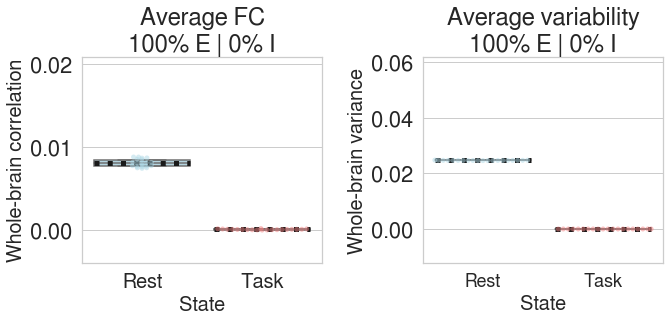

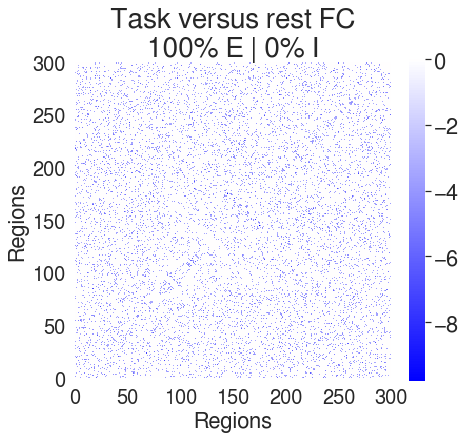

In [5]:
restfc = []
taskfc = []
restvar = []
taskvar = []
for i in range(nsubjs):
    tmp = np.corrcoef(restdata[i][:,100:])
    np.fill_diagonal(tmp,0)
    restfc.append(np.arctanh(tmp))
    tmp = np.corrcoef(taskdata[i][:,100:])
    np.fill_diagonal(tmp,0)
    taskfc.append(np.arctanh(tmp))
    restvar.append(np.var(restdata[i][:,100:],axis=1))
    taskvar.append(np.var(taskdata[i][:,100:],axis=1))
restfc = np.asarray(restfc)
taskfc = np.asarray(taskfc)
restvar = np.asarray(restvar)
taskvar = np.asarray(taskvar)

# Perform a Group-level analysis; average across all tasks
taskfc_avg = np.mean(np.mean(taskfc,axis=2),axis=1) # Compute average correlation for each subject
restfc_avg = np.mean(np.mean(restfc,axis=2),axis=1)
fcstats = np.zeros((3,)) # avg r, t, p
fcstats[0] = np.mean(taskfc_avg-restfc_avg)
fcstats[1],fcstats[2] = stats.ttest_rel(taskfc_avg,restfc_avg)
print('Average correlation difference between task versus rest:', fcstats[0])
print('Task vs. Rest average FC difference: t =', fcstats[1], '| p =', fcstats[2])

taskvar_avg = np.mean(taskvar,axis=1)
restvar_avg = np.mean(restvar,axis=1)
varstats = np.zeros((3,))
varstats[0] = np.mean(taskvar_avg-restvar_avg)
varstats[1],varstats[2] = stats.ttest_rel(taskvar_avg,restvar_avg)
print('Average SD difference between task versus rest:', varstats[0])
print('Task vs. Rest average SD difference: t =', varstats[1], '| p =', varstats[2])

## Plot
df_stat = {}
df_stat['Subject'] = []
df_stat['FC'] = []
df_stat['Var'] = []
df_stat['State'] = []

# For rest state
df_stat['State'].extend(np.repeat('Rest',nsubjs))
df_stat['Subject'].extend(np.arange(nsubjs))
df_stat['FC'].extend(restfc_avg)
df_stat['Var'].extend(restvar_avg)
# For task state
df_stat['State'].extend(np.repeat('Task',nsubjs))
df_stat['Subject'].extend(np.arange(nsubjs))
df_stat['FC'].extend(taskfc_avg)
df_stat['Var'].extend(taskvar_avg)


df_stat = pd.DataFrame(df_stat)

#### Global variability FC plots
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('Average FC\n100% E | 0% I',fontsize=24)
sns.boxplot(x="State",y="FC",data=df_stat,
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(x="State",y="FC",
            palette=["#add8e6","#f08080"],
            data=df_stat,alpha=0.5)
plt.ylabel('Whole-brain correlation',fontsize=20)
plt.xlabel('State', fontsize=20)
plt.ylim([np.min(df_stat['FC'])-np.std(df_stat['FC']),np.max(df_stat['FC'])+3*np.std(df_stat['FC'])]);
plt.xticks(fontsize=20)

plt.subplot(122)
plt.title('Average variability\n100% E | 0% I',fontsize=24)
sns.boxplot(x="State",y="Var",data=df_stat,
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(x="State",y="Var",
            palette=["#add8e6","#f08080"],
            data=df_stat,alpha=0.5)
plt.ylabel('Whole-brain variance',fontsize=20)
plt.xlabel('State', fontsize=20)
plt.xticks(fontsize=18)
plt.ylim([np.min(df_stat['Var'])-np.std(df_stat['Var']),np.max(df_stat['Var'])+3*np.std(df_stat['Var'])]);
plt.tight_layout()
plt.savefig('Analysis6c_TaskVsRestBoxPlot_AllE_Random.png',dpi=150)

#### FC Matrix plot Perform a Group-level analysis; average across all tasks
diffFC_t, diffFC_p = stats.ttest_rel(taskfc,restfc,axis=0)

triu_ind = np.triu_indices(nunits,k=1)
tril_ind = np.triu_indices(nunits,k=1)
diffFC_q = np.zeros(diffFC_t.shape)
diffFC_q[triu_ind] = mc.fdrcorrection0(diffFC_p[triu_ind])[0]
diffFC_q = diffFC_q + diffFC_q.T

# diffFC_t_sig = np.multiply(diffFC_t, diffFC_p<0.05)
diffFC_t_sig = np.multiply(diffFC_t, diffFC_q)

plt.figure(figsize=(7,7))
plt.title('Task versus rest FC\n100% E | 0% I',fontsize=28)
ax = sns.heatmap(diffFC_t_sig,square=True,center=0,cmap='bwr',cbar=True,cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.xticks(np.arange(0,nunits+1,50),np.arange(0,nunits+1,50),fontsize=20,rotation=0)
plt.yticks(np.arange(0,nunits+1,50),np.arange(0,nunits+1,50),fontsize=20)
plt.ylabel('Regions',fontsize=22)
plt.xlabel('Regions',fontsize=22)
plt.tight_layout()
plt.savefig('Analysis6c_TaskVsRestFCMat_AllE_Random.png',dpi=150)

## 2.2 Run group simulation, sparse, excitatory and inhibitory
#### $\mu=1$ | $\sigma =1.2$ | 20% of negative weights

In [6]:
model6c = reload(model6c)
synweights=1.2 # All connections will be E

#### Run simulation using multiprocessing
inputs = []
for i in range(nsubjs):
    seed = np.random.randint(1000000)
    inputs.append((i,seed,ncommunities,innetwork_dsity,outnetwork_dsity,nodespercommunity,s,g,synweights))
pool = mp.Pool(processes=nproc)
results = pool.starmap_async(model6c.subjectSimulation, inputs).get()
pool.close()
pool.join()

restdata = []
taskdata = []
for result in results:
    restdata.append(result[0])
    taskdata.append(result[1])



Running subject 19
Running subject 18
Running subject 16
Running subject 14
Running subject 5
Running subject 9
Running subject 10
Running subject 7
Running subject 8
Running subject 4
Running subject 3
Running subject 0
Running subject 17
Running subject 12
Running subject 11
Running subject 6
Running subject 1
Running subject 2
Running subject 13
Running subject 15


#### Compute FC and variability for all subjects

Average correlation difference between task versus rest: -0.007731106506759626
Task vs. rest average FC difference: t = -83.63232082160326 | p = 7.400181377701152e-26
Average SD difference between task versus rest: -0.02248566740242871
Task vs. rest average SD difference: t = -162.90508193890372 | p = 2.3737799951493964e-31


/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


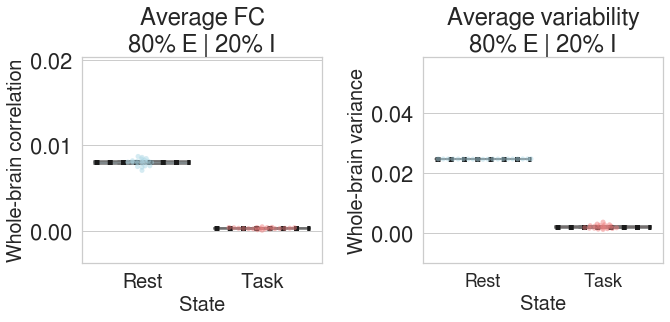

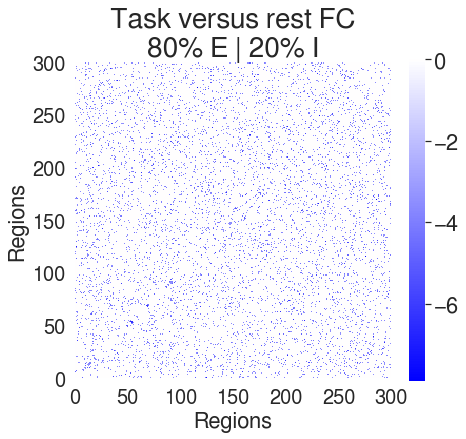

In [7]:
restfc = []
taskfc = []
restvar = []
taskvar = []
for i in range(nsubjs):
    tmp = np.corrcoef(restdata[i][:,100:])
    np.fill_diagonal(tmp,0)
    restfc.append(np.arctanh(tmp))
    tmp = np.corrcoef(taskdata[i][:,100:])
    np.fill_diagonal(tmp,0)
    taskfc.append(np.arctanh(tmp))
    restvar.append(np.var(restdata[i][:,100:],axis=1))
    taskvar.append(np.var(taskdata[i][:,100:],axis=1))
restfc = np.asarray(restfc)
taskfc = np.asarray(taskfc)
restvar = np.asarray(restvar)
taskvar = np.asarray(taskvar)

# Perform a Group-level analysis; average across all tasks
taskfc_avg = np.mean(np.mean(taskfc,axis=2),axis=1) # Compute average correlation for each subject
restfc_avg = np.mean(np.mean(restfc,axis=2),axis=1)
fcstats = np.zeros((3,)) # avg r, t, p
fcstats[0] = np.mean(taskfc_avg-restfc_avg)
fcstats[1],fcstats[2] = stats.ttest_rel(taskfc_avg,restfc_avg)
print('Average correlation difference between task versus rest:', fcstats[0])
print('Task vs. rest average FC difference: t =', fcstats[1], '| p =', fcstats[2])

taskvar_avg = np.mean(taskvar,axis=1)
restvar_avg = np.mean(restvar,axis=1)
varstats = np.zeros((3,))
varstats[0] = np.mean(taskvar_avg-restvar_avg)
varstats[1],varstats[2] = stats.ttest_rel(taskvar_avg,restvar_avg)
print('Average SD difference between task versus rest:', varstats[0])
print('Task vs. rest average SD difference: t =', varstats[1], '| p =', varstats[2])

## Plot
df_stat = {}
df_stat['Subject'] = []
df_stat['FC'] = []
df_stat['Var'] = []
df_stat['State'] = []

# For rest state
df_stat['State'].extend(np.repeat('Rest',nsubjs))
df_stat['Subject'].extend(np.arange(nsubjs))
df_stat['FC'].extend(restfc_avg)
df_stat['Var'].extend(restvar_avg)
# For task state
df_stat['State'].extend(np.repeat('Task',nsubjs))
df_stat['Subject'].extend(np.arange(nsubjs))
df_stat['FC'].extend(taskfc_avg)
df_stat['Var'].extend(taskvar_avg)


df_stat = pd.DataFrame(df_stat)

#### Global variability FC plots
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('Average FC\n80% E | 20% I',fontsize=24)
sns.boxplot(x="State",y="FC",data=df_stat,
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(x="State",y="FC",
            palette=["#add8e6","#f08080"],
            data=df_stat,alpha=0.5)
plt.ylabel('Whole-brain correlation',fontsize=20)
plt.xlabel('State', fontsize=20)
plt.ylim([np.min(df_stat['FC'])-np.std(df_stat['FC']),np.max(df_stat['FC'])+3*np.std(df_stat['FC'])]);
plt.xticks(fontsize=20)

plt.subplot(122)
plt.title('Average variability\n80% E | 20% I',fontsize=24)
sns.boxplot(x="State",y="Var",data=df_stat,
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(x="State",y="Var",
            palette=["#add8e6","#f08080"],
            data=df_stat,alpha=0.5)
plt.ylabel('Whole-brain variance',fontsize=20)
plt.xlabel('State', fontsize=20)
plt.xticks(fontsize=18)
plt.ylim([np.min(df_stat['Var'])-np.std(df_stat['Var']),np.max(df_stat['Var'])+3*np.std(df_stat['Var'])]);
plt.tight_layout()
plt.savefig('Analysis6c_TaskVsRestBoxPlot_80E20I_Random.png',dpi=150)

#### FC Matrix plot Perform a Group-level analysis; average across all tasks
diffFC_t, diffFC_p = stats.ttest_rel(taskfc,restfc,axis=0)

triu_ind = np.triu_indices(nunits,k=1)
tril_ind = np.triu_indices(nunits,k=1)
diffFC_q = np.zeros(diffFC_t.shape)
diffFC_q[triu_ind] = mc.fdrcorrection0(diffFC_p[triu_ind])[0]
diffFC_q = diffFC_q + diffFC_q.T

# diffFC_t_sig = np.multiply(diffFC_t, diffFC_p<0.05)
diffFC_t_sig = np.multiply(diffFC_t, diffFC_q)

plt.figure(figsize=(7,7))
plt.title('Task versus rest FC\n80% E | 20% I',fontsize=28)
ax = sns.heatmap(diffFC_t_sig,square=True,center=0,cmap='bwr',cbar=True,cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.xticks(np.arange(0,nunits+1,50),np.arange(0,nunits+1,50),fontsize=20,rotation=0)
plt.yticks(np.arange(0,nunits+1,50),np.arange(0,nunits+1,50),fontsize=20)
plt.ylabel('Regions',fontsize=22)
plt.xlabel('Regions',fontsize=22)
plt.tight_layout()
plt.savefig('Analysis6c_TaskVsRestFCMat_80E20I_Random.png',dpi=150)

# 3.0 Group simulation - sparse, clustered connectivity
* 3.1 - Excitatory connections only
* 3.2 - Excitatory and inhibitory connections (about 80/20% difference)


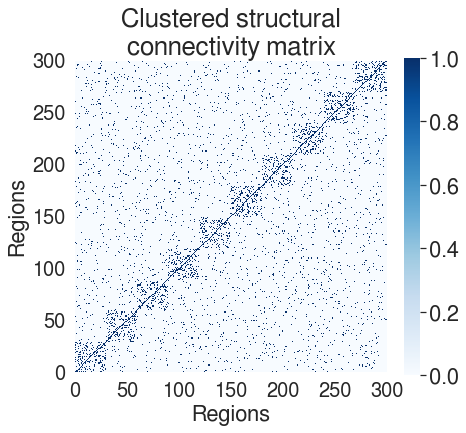

In [8]:
#### 1. Define network model parameters
# Parameters for subject's networks
ncommunities = 10 # Number of communities
nunits = 300
innetwork_dsity = 0.2 # within network connectivity density
outnetwork_dsity = 0.03 # out of network connectivity density
nodespercommunity=int(nunits/ncommunities)
s=1.0
g=2.0
nsubjs = 20

#### 2. Print out example structural matrix
mat = model6c.generateNetwork(ncommunities=ncommunities,innetwork_dsity=innetwork_dsity, outnetwork_dsity=outnetwork_dsity,
                      nodespercommunity=nodespercommunity,showplot=False)
np.fill_diagonal(mat,1)
plt.figure(figsize=(7,7))
plt.title('Clustered structural\nconnectivity matrix',fontsize=26)
ax = sns.heatmap(mat>0,square=True,cmap='Blues',cbar_kws={'fraction':0.046})
plt.xticks(np.arange(0,nunits+1,50),np.arange(0,nunits+1,50),fontsize=20,rotation=0)
plt.yticks(np.arange(0,nunits+1,50),np.arange(0,nunits+1,50),fontsize=20)
plt.ylabel('Regions',fontsize=22)
plt.xlabel('Regions',fontsize=22)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('Analysis6c_StructuralMat_Clustered.png',dpi=150)

## 2.1 Run group simulation, excitatory only
#### $\mu=1$ | $\sigma =0.2$ | 0% negative weights

In [9]:
model6c = reload(model6c)
synweights=0.2 # All connections will be E

#### Run simulation using multiprocessing
inputs = []
for i in range(nsubjs):
    seed = np.random.randint(1000000)
    inputs.append((i,seed,ncommunities,innetwork_dsity,outnetwork_dsity,nodespercommunity,s,g,synweights))
pool = mp.Pool(processes=nproc)
results = pool.starmap_async(model6c.subjectSimulation, inputs).get()
pool.close()
pool.join()

restdata = []
taskdata = []
for result in results:
    restdata.append(result[0])
    taskdata.append(result[1])



Running subject 11
Running subject 16
Running subject 7
Running subject 6
Running subject 1
Running subject 4
Running subject 8
Running subject 0
Running subject 3
Running subject 9
Running subject 14
Running subject 17
Running subject 2
Running subject 15
Running subject 19
Running subject 10
Running subject 13
Running subject 18
Running subject 5
Running subject 12


#### Compute FC and variability for all subjects

Average correlation difference between task versus rest: -0.007267077970468418
Task vs. Rest average FC difference: t = -87.77530997628564 | p = 2.9597663639611584e-26
Average SD difference between task versus rest: -0.02378791912023087
Task vs. Rest average SD difference: t = -952.2453404324236 | p = 6.437245879112518e-46


/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


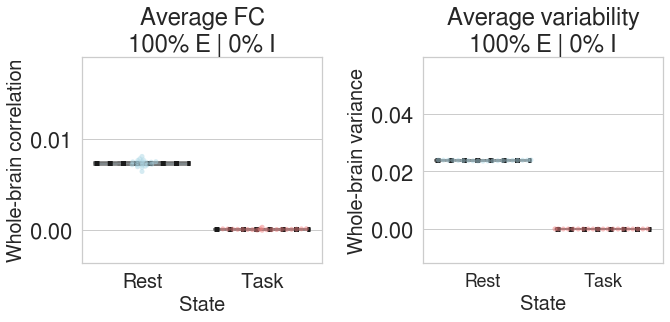

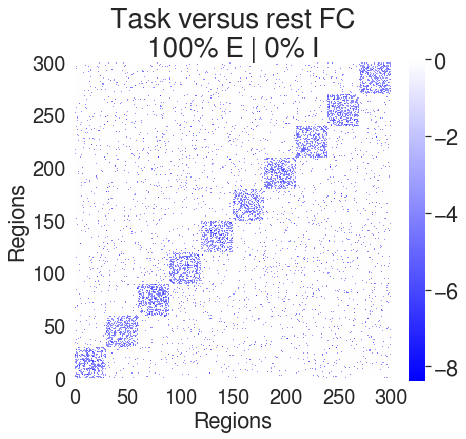

In [10]:
restfc = []
taskfc = []
restvar = []
taskvar = []
for i in range(nsubjs):
    tmp = np.corrcoef(restdata[i][:,100:])
    np.fill_diagonal(tmp,0)
    restfc.append(np.arctanh(tmp))
    tmp = np.corrcoef(taskdata[i][:,100:])
    np.fill_diagonal(tmp,0)
    taskfc.append(np.arctanh(tmp))
    restvar.append(np.var(restdata[i][:,100:],axis=1))
    taskvar.append(np.var(taskdata[i][:,100:],axis=1))
restfc = np.asarray(restfc)
taskfc = np.asarray(taskfc)
restvar = np.asarray(restvar)
taskvar = np.asarray(taskvar)


# Perform a Group-level analysis; average across all tasks
taskfc_avg = np.mean(np.mean(taskfc,axis=2),axis=1) # Compute average correlation for each subject
restfc_avg = np.mean(np.mean(restfc,axis=2),axis=1)
fcstats = np.zeros((3,)) # avg r, t, p
fcstats[0] = np.mean(taskfc_avg-restfc_avg)
fcstats[1],fcstats[2] = stats.ttest_rel(taskfc_avg,restfc_avg)
print('Average correlation difference between task versus rest:', fcstats[0])
print('Task vs. Rest average FC difference: t =', fcstats[1], '| p =', fcstats[2])

taskvar_avg = np.mean(taskvar,axis=1)
restvar_avg = np.mean(restvar,axis=1)
varstats = np.zeros((3,))
varstats[0] = np.mean(taskvar_avg-restvar_avg)
varstats[1],varstats[2] = stats.ttest_rel(taskvar_avg,restvar_avg)
print('Average SD difference between task versus rest:', varstats[0])
print('Task vs. Rest average SD difference: t =', varstats[1], '| p =', varstats[2])

## Plot
df_stat = {}
df_stat['Subject'] = []
df_stat['FC'] = []
df_stat['Var'] = []
df_stat['State'] = []

# For rest state
df_stat['State'].extend(np.repeat('Rest',nsubjs))
df_stat['Subject'].extend(np.arange(nsubjs))
df_stat['FC'].extend(restfc_avg)
df_stat['Var'].extend(restvar_avg)
# For task state
df_stat['State'].extend(np.repeat('Task',nsubjs))
df_stat['Subject'].extend(np.arange(nsubjs))
df_stat['FC'].extend(taskfc_avg)
df_stat['Var'].extend(taskvar_avg)


df_stat = pd.DataFrame(df_stat)

#### Global variability FC plots
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('Average FC\n100% E | 0% I',fontsize=24)
sns.boxplot(x="State",y="FC",data=df_stat,
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(x="State",y="FC",
            palette=["#add8e6","#f08080"],
            data=df_stat,alpha=0.5)
plt.ylabel('Whole-brain correlation',fontsize=20)
plt.xlabel('State', fontsize=20)
plt.ylim([np.min(df_stat['FC'])-np.std(df_stat['FC']),np.max(df_stat['FC'])+3*np.std(df_stat['FC'])]);
plt.xticks(fontsize=20)

plt.subplot(122)
plt.title('Average variability\n100% E | 0% I',fontsize=24)
sns.boxplot(x="State",y="Var",data=df_stat,
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(x="State",y="Var",
            palette=["#add8e6","#f08080"],
            data=df_stat,alpha=0.5)
plt.ylabel('Whole-brain variance',fontsize=20)
plt.xlabel('State', fontsize=20)
plt.xticks(fontsize=18)
plt.ylim([np.min(df_stat['Var'])-np.std(df_stat['Var']),np.max(df_stat['Var'])+3*np.std(df_stat['Var'])]);
plt.tight_layout()
plt.savefig('Analysis6c_TaskVsRestBoxPlot_AllE_Clustered.png',dpi=150)

#### FC Matrix plot Perform a Group-level analysis; average across all tasks
diffFC_t, diffFC_p = stats.ttest_rel(taskfc,restfc,axis=0)

triu_ind = np.triu_indices(nunits,k=1)
tril_ind = np.triu_indices(nunits,k=1)
diffFC_q = np.zeros(diffFC_t.shape)
diffFC_q[triu_ind] = mc.fdrcorrection0(diffFC_p[triu_ind])[0]
diffFC_q = diffFC_q + diffFC_q.T

# diffFC_t_sig = np.multiply(diffFC_t, diffFC_p<0.05)
diffFC_t_sig = np.multiply(diffFC_t, diffFC_q)

plt.figure(figsize=(7,7))
plt.title('Task versus rest FC\n100% E | 0% I',fontsize=28)
ax = sns.heatmap(diffFC_t_sig,square=True,center=0,cmap='bwr',cbar=True,cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.xticks(np.arange(0,nunits+1,50),np.arange(0,nunits+1,50),fontsize=20,rotation=0)
plt.yticks(np.arange(0,nunits+1,50),np.arange(0,nunits+1,50),fontsize=20)
plt.ylabel('Regions',fontsize=22)
plt.xlabel('Regions',fontsize=22)
plt.tight_layout()
plt.savefig('Analysis6c_TaskVsRestFCMat_AllE_Clustered.png',dpi=150)

## 2.2 Run group simulation, sparse, excitatory and inhibitory
#### $\mu=1$ | $\sigma =1.2$ | 20% of negative weights

In [11]:
model6c = reload(model6c)
synweights=1.2 # All connections will be E

#### Run simulation using multiprocessing
inputs = []
for i in range(nsubjs):
    seed = np.random.randint(1000000)
    inputs.append((i,seed,ncommunities,innetwork_dsity,outnetwork_dsity,nodespercommunity,s,g,synweights))
pool = mp.Pool(processes=nproc)
results = pool.starmap_async(model6c.subjectSimulation, inputs).get()
pool.close()
pool.join()

restdata = []
taskdata = []
for result in results:
    restdata.append(result[0])
    taskdata.append(result[1])



Running subject 0
Running subject 5
Running subject 4
Running subject 3
Running subject 18
Running subject 15
Running subject 8
Running subject 10
Running subject 19
Running subject 6
Running subject 14
Running subject 9
Running subject 11
Running subject 12
Running subject 17
Running subject 1
Running subject 13
Running subject 2
Running subject 7
Running subject 16


#### Compute FC and variability for all subjects

Average correlation difference between task versus rest: -0.0067927784373220165
Task vs. Rest average FC difference: t = -81.09354762335502 | p = 1.3271945411642037e-25
Average SD difference between task versus rest: -0.021401429579585747
Task vs. Rest average SD difference: t = -198.66768107240085 | p = 5.4790135376674206e-33


/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/tito/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


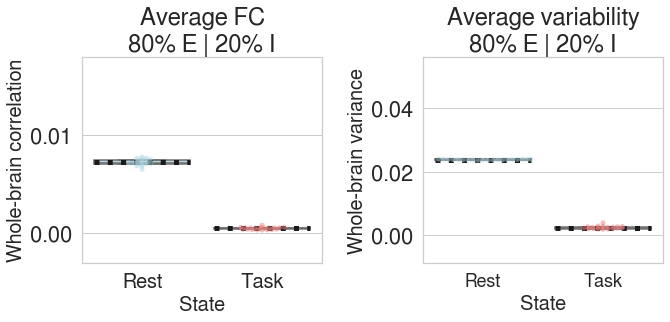

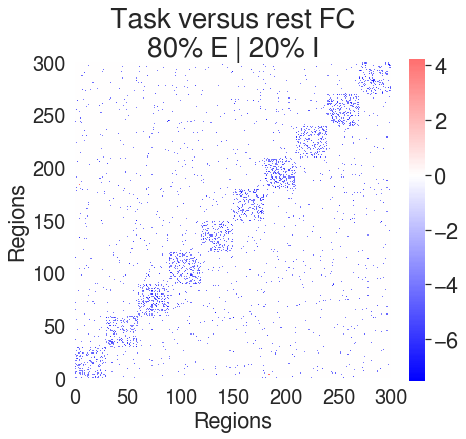

In [12]:
restfc = []
taskfc = []
restvar = []
taskvar = []
for i in range(nsubjs):
    tmp = np.corrcoef(restdata[i][:,100:])
    np.fill_diagonal(tmp,0)
    restfc.append(np.arctanh(tmp))
    tmp = np.corrcoef(taskdata[i][:,100:])
    np.fill_diagonal(tmp,0)
    taskfc.append(np.arctanh(tmp))
    restvar.append(np.var(restdata[i][:,100:],axis=1))
    taskvar.append(np.var(taskdata[i][:,100:],axis=1))
restfc = np.asarray(restfc)
taskfc = np.asarray(taskfc)
restvar = np.asarray(restvar)
taskvar = np.asarray(taskvar)

# Perform a Group-level analysis; average across all tasks
taskfc_avg = np.mean(np.mean(taskfc,axis=2),axis=1) # Compute average correlation for each subject
restfc_avg = np.mean(np.mean(restfc,axis=2),axis=1)
fcstats = np.zeros((3,)) # avg r, t, p
fcstats[0] = np.mean(taskfc_avg-restfc_avg)
fcstats[1],fcstats[2] = stats.ttest_rel(taskfc_avg,restfc_avg)
print('Average correlation difference between task versus rest:', fcstats[0])
print('Task vs. Rest average FC difference: t =', fcstats[1], '| p =', fcstats[2])

taskvar_avg = np.mean(taskvar,axis=1)
restvar_avg = np.mean(restvar,axis=1)
varstats = np.zeros((3,))
varstats[0] = np.mean(taskvar_avg-restvar_avg)
varstats[1],varstats[2] = stats.ttest_rel(taskvar_avg,restvar_avg)
print('Average SD difference between task versus rest:', varstats[0])
print('Task vs. Rest average SD difference: t =', varstats[1], '| p =', varstats[2])

## Plot
df_stat = {}
df_stat['Subject'] = []
df_stat['FC'] = []
df_stat['Var'] = []
df_stat['State'] = []

# For rest state
df_stat['State'].extend(np.repeat('Rest',nsubjs))
df_stat['Subject'].extend(np.arange(nsubjs))
df_stat['FC'].extend(restfc_avg)
df_stat['Var'].extend(restvar_avg)
# For task state
df_stat['State'].extend(np.repeat('Task',nsubjs))
df_stat['Subject'].extend(np.arange(nsubjs))
df_stat['FC'].extend(taskfc_avg)
df_stat['Var'].extend(taskvar_avg)


df_stat = pd.DataFrame(df_stat)

#### Global variability FC plots
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('Average FC\n80% E | 20% I',fontsize=24)
sns.boxplot(x="State",y="FC",data=df_stat,
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(x="State",y="FC",
            palette=["#add8e6","#f08080"],
            data=df_stat,alpha=0.5)
plt.ylabel('Whole-brain correlation',fontsize=20)
plt.xlabel('State', fontsize=20)
plt.ylim([np.min(df_stat['FC'])-np.std(df_stat['FC']),np.max(df_stat['FC'])+3*np.std(df_stat['FC'])]);
plt.xticks(fontsize=20)

plt.subplot(122)
plt.title('Average variability\n80% E | 20% I',fontsize=24)
sns.boxplot(x="State",y="Var",data=df_stat,
           palette=["#add8e6","#f08080"],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(x="State",y="Var",
            palette=["#add8e6","#f08080"],
            data=df_stat,alpha=0.5)
plt.ylabel('Whole-brain variance',fontsize=20)
plt.xlabel('State', fontsize=20)
plt.xticks(fontsize=18)
plt.ylim([np.min(df_stat['Var'])-np.std(df_stat['Var']),np.max(df_stat['Var'])+3*np.std(df_stat['Var'])]);
plt.tight_layout()
plt.savefig('Analysis6c_TaskVsRestBoxPlot_80E20I_Clustered.png',dpi=150)

#### FC Matrix plot Perform a Group-level analysis; average across all tasks
diffFC_t, diffFC_p = stats.ttest_rel(taskfc,restfc,axis=0)

triu_ind = np.triu_indices(nunits,k=1)
tril_ind = np.triu_indices(nunits,k=1)
diffFC_q = np.zeros(diffFC_t.shape)
diffFC_q[triu_ind] = mc.fdrcorrection0(diffFC_p[triu_ind])[0]
diffFC_q = diffFC_q + diffFC_q.T

# diffFC_t_sig = np.multiply(diffFC_t, diffFC_p<0.05)
diffFC_t_sig = np.multiply(diffFC_t, diffFC_q)

plt.figure(figsize=(7,7))
plt.title('Task versus rest FC\n80% E | 20% I',fontsize=28)
ax = sns.heatmap(diffFC_t_sig,square=True,center=0,cmap='bwr',cbar=True,cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.xticks(np.arange(0,nunits+1,50),np.arange(0,nunits+1,50),fontsize=20,rotation=0)
plt.yticks(np.arange(0,nunits+1,50),np.arange(0,nunits+1,50),fontsize=20)
plt.ylabel('Regions',fontsize=22)
plt.xlabel('Regions',fontsize=22)
plt.tight_layout()
plt.savefig('Analysis6c_TaskVsRestFCMat_80E20I_Clustered.png',dpi=150)